## Test of the processing pipeline that will take place for every metric
> This file's purpose is to **test** the new approach we will be using to complete the project.

## Generative question:
- How does investment criteria affect the returns of a portfolio?

### Hypothesis:
- Some metrics or percentiles of them will yield portfolios with higher returns than the SP500 consistently over time.

### Steps:
1. [Load data for a single metric](#step-1)
2. [Limit span of data from 2000Q1 to 2023Q2](#step-2)
3. [Clean data if needed (outliers, missing values, etc. Maybe calculate No. of missing values, etc.)](#step-3)
4. [Plot distribution of data. We need to make sure data was fetched correctly](#step-4)
5. [Save cleaned data (.pickle)](#step-5)
6. [Select study and investment periods](#step-6)
7. [Calculate average of metric per company](#step-7)
8. [Calculate central tendency and dispersion measures for the averages](#step-8)
9. [Create portfolios of companies based percentiles on the average (or median) of metric](#step-9)
10. [Calculate returns of portfolios and SP500](#step-10)
11. [Test for statistical significance of the difference in returns](#step-11)
12. [Export results](#step-12)

### Analysis parameters

- [Parameters](#parameters)

### Parameters


In [45]:
name_of_metric = "Pretax ROA" # Based on the keys for the file_style_configs_by_metric dict
study_period_start = "2000Q1" # In YYYYqq format
study_period_length = 40 # In quarters
invest_period_length = 4 # In quarters
quantile_criterion = 0.75 # Criterion to split companies into portfolios

In [46]:
import random

import pandas as pd
import numpy as np

import yfinance as yf

from scipy import stats
from scipy.ndimage import uniform_filter1d
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

from tabulate import tabulate

# Add cwd/.. to path so the imports to my user defined packages work
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
from src.data_fetchers.metrics_fetcher import MetricsFetcher
from src.data_fetchers.classification_fetcher import ClassificationFetcher
from src.data_fetchers.returns_fetcher import ReturnsFetcher
from src.configs.file_style_configs_by_metric import file_style_configs_by_metric

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000


### Step 1
[Steps backlink](#steps)

In [47]:
data_path = os.path.join("..", "data", "companies_data")
fetcher = MetricsFetcher(data_path, file_style_configs_by_metric)

ROA_df = fetcher.fetch(name_of_metric, os.path.join("..", "data", "pickled_data"))

def change_df_index_to_period(df: pd.DataFrame):
    df.index = pd.to_datetime(df.index)
    df.index = df.index.to_period("Q")

try:
    change_df_index_to_period(ROA_df)
except TypeError: # It's already PeriodIndex, this can happen when reading cleaned data
    ...


ROA_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 80 entries, 2000Q1 to 2019Q4
Freq: Q-DEC
Columns: 247 entries, AAPL to ZION
dtypes: float64(247)
memory usage: 155.0 KB


We have data from 2023Q3-2024Q4, we think these are forecasted values. They only appear for a small selection of companies.

### Step 2
[Steps backlink](#steps)

In [48]:
def select_range_of_data(df: pd.DataFrame, period_start: pd.Period, period_end: pd.Period) -> pd.DataFrame:
    return df[period_start:period_end]

ROA_df = select_range_of_data(ROA_df, pd.Period("2000Q1"), pd.Period("2019Q4"))
print(min(ROA_df.index), max(ROA_df.index))

2000Q1 2019Q4


### Step 3
[Steps backlink](#steps)

Before plotting the distribution of the data and checking for outliers, we need to make sure we are working with complete data.
So, will explore if there are missing values

In [49]:
print("Number of NaNs: ", ROA_df.isna().sum().sum())

non_float_count = (ROA_df.map(lambda x: not isinstance(x, (float, np.floating)))).sum().sum()
print("Number of non floats: ", non_float_count)

Number of NaNs:  0
Number of non floats:  0


In order to handle missing values, we will use the following approach:
- If there are less than 4 consecutive missing values, we will impute them based on the quarter from the previous year.
- If there are more than 4 consecutive missing values, we will drop the company from the dataset. Too many missing values will affect the results of the analysis.

In [50]:
def handle_nans(df: pd.DataFrame) -> pd.DataFrame:
    handle_log = ""

    df = df.copy()
    nan_mask = ROA_df.isnull()
    consecutive_nans = nan_mask.rolling(window=5).sum()
    columns_to_drop = ROA_df.columns[consecutive_nans.max() > 4]
    df = df.drop(columns=columns_to_drop)
    word_ending = "ies" if len(columns_to_drop) > 1 else "y"
    handle_log += f"\nDropped: {len(columns_to_drop)} compan{word_ending} from dataset"

    elements_in_df = df.size
    nans_before_ffill = df.isnull().sum().sum()
    df = df.fillna(df.shift(4)) # Rows 5 and onwards get imputed with the value from the same quarter last year
    nans_before_bfill = df.isnull().sum().sum()
    df = df.fillna(df.shift(-4)) # For rows 1 - 4 we backfill based on the values from the same quarter next year

    handle_log += f"\nValues filled with past observations: {nans_before_ffill}. They represent {100*nans_before_ffill/elements_in_df:.2f} % of the data"
    handle_log += f"\nValues filled with future observations: {nans_before_bfill}. They represent {100*nans_before_bfill/elements_in_df:.2f} % of the data"

    print(handle_log)

    return df, columns_to_drop

ROA_df, dropped_companies = handle_nans(ROA_df)
print("Dropped companies", [tick for tick in dropped_companies])




Dropped: 0 company from dataset
Values filled with past observations: 0. They represent 0.00 % of the data
Values filled with future observations: 0. They represent 0.00 % of the data
Dropped companies []


### Step 4
[Steps backlink](#steps)

We will include outlier handling and distribution plotting in the same step.

There is a big problem when dealing with outliers in time series in the manner that the traditional 1.5*IQR approach does. sometimes volatility of markets or specific events lead to "shocks" in the time series data. So, instead of right out deleting them, we will filter the time series to expose the underlying patterns and obtain cleaner data. One shortcoming of this approach is that depending on the smoothing window we will be removing seasonality from the data.

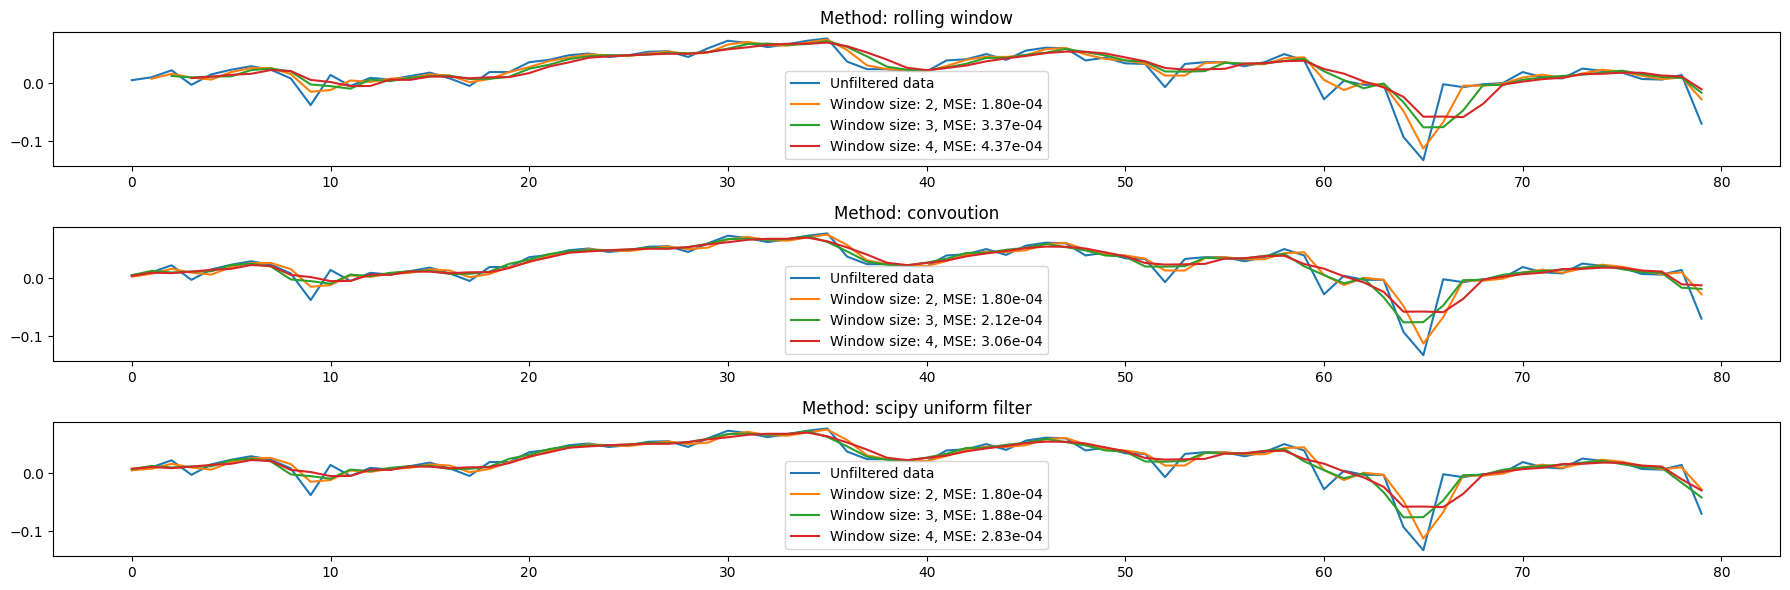

In [51]:
data = ROA_df.iloc[:, random.randint(0, len(ROA_df.columns)-1)].copy() # Let's pick one time series at random
data.index = data.index.to_timestamp()

# Let's compare the results of different alternatives
methods = {
    "rolling window": lambda i, data: data.rolling(window=i).mean().to_numpy(),
    "convoution": lambda i, data: np.convolve(data, np.ones(i) / i, mode='same'),
    "scipy uniform filter": lambda i, data: uniform_filter1d(data, size=i),
}

fig, axs = plt.subplots(3, 1, figsize=(18, 6))

for j, [method_name, method] in enumerate(methods.items()):
    axs[j].plot(data.to_numpy(), label="Unfiltered data")
    for window_size in range(2, 5):
        y = method(window_size, data)
        mse = mean_squared_error(data.to_numpy()[window_size:], y[window_size:]) # [window_size:] since some methods can return NaN for n < window_size
        axs[j].plot(y, label=f"Window size: {window_size}, MSE: {mse:.2e}")


    axs[j].set_title(f"Method: {method_name}")
    axs[j].legend()

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

Any method to smooth/filter our data is performing equally for a window size of two. However, the scipy uniform filter ajusts to the first values faster than the other methods. So, we will use it. As seen in the plots, the oscillation that can be attributed to seasonal changes from quarter to quarter is reduced, in addition, those changes have been delayed by one quarter.
The above graph also shines a light on the fact that the data needs be normalized. Big values are hiding the underlying patterns of the data. Although this is an important consideration, we will not normalize the data for now, our portfolio creation is based on the median of the metric, so the values of the metric are not important, only their relative position.

In [52]:
window_size = 2
ROA_df_smoothed = ROA_df.copy()
for col in ROA_df.columns:
    ROA_df_smoothed[col] = uniform_filter1d(ROA_df_smoothed[col], window_size)

Let's compare the distributions of the data before and after filtering.

In [53]:

def remove_outliers(stacked_df, iqr_times: int):
    Q1 = stacked_df.quantile(0.25)
    Q3 = stacked_df.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - iqr_times * IQR
    upper_bound = Q3 + iqr_times * IQR

    non_outlier_mask = stacked_df.between(lower_bound, upper_bound)
    return stacked_df[non_outlier_mask], stacked_df[~non_outlier_mask]

stacked_df_not_smoothed = ROA_df.stack() # Stack frame for plotting ease
stacked_df_no_outliers_not_smoothed, stacked_outliers_not_smoothed = remove_outliers(stacked_df_not_smoothed, 1.5)
stacked_df_smoothed = ROA_df_smoothed.stack() # Stack frame for plotting ease
stacked_df_no_outliers_smoothed, stacked_outliers_smoothed = remove_outliers(stacked_df_smoothed, 1.5)


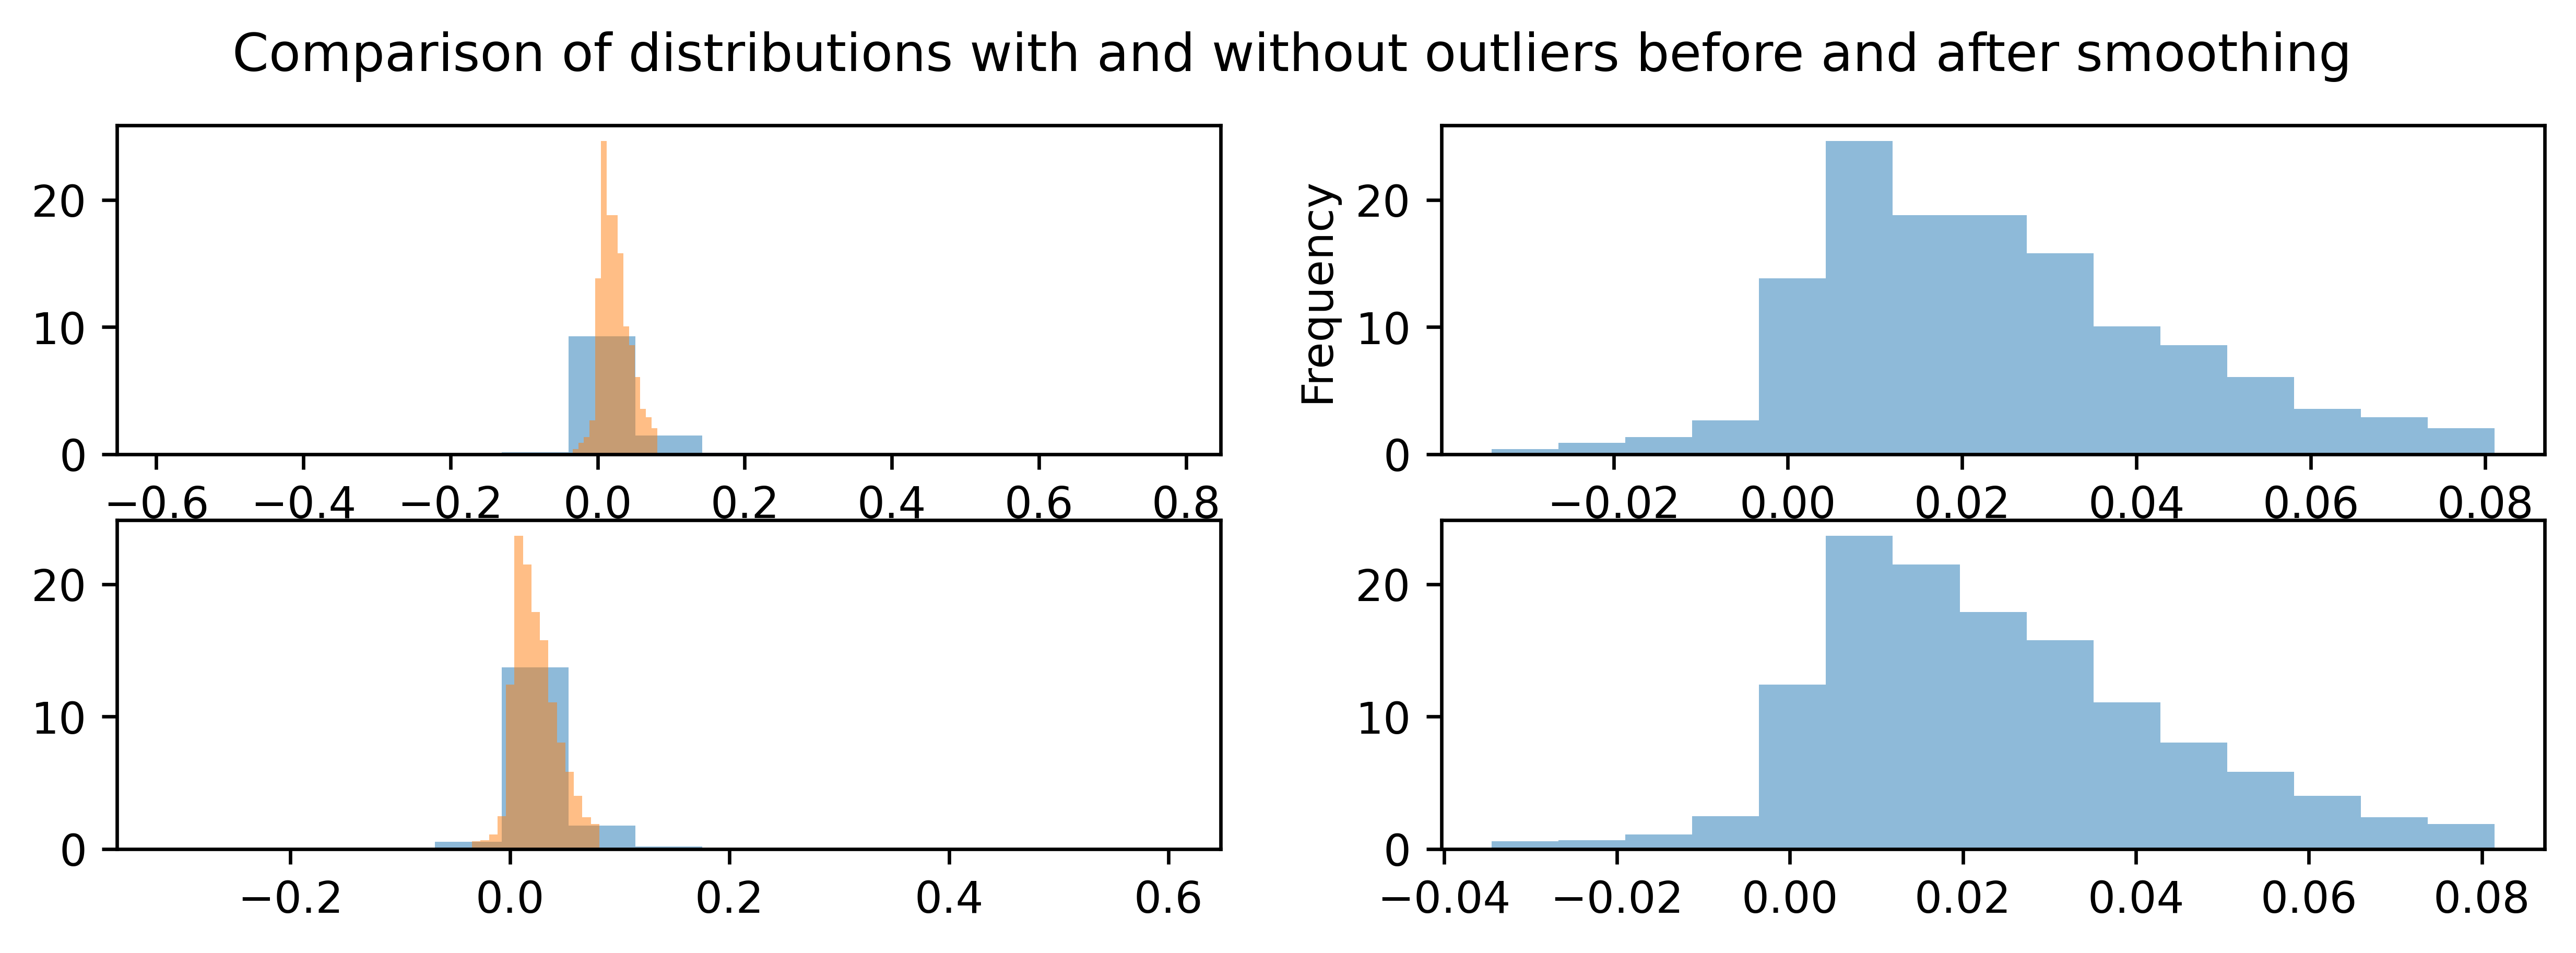

In [54]:
stacked_dfs = [[stacked_df_not_smoothed, stacked_df_no_outliers_not_smoothed],
               [stacked_df_smoothed, stacked_df_no_outliers_smoothed]]

fig, axes = plt.subplots(2, 2, figsize=(10, 3), dpi=600)
hist_options = {
    "bins": 15,
    "alpha": 0.5,
    "density": True, # Nomalize (AUC=1) so shapes are comparable
}

for i in range(len(stacked_dfs)):
    for j in range(len(stacked_dfs[i])):
        stacked_df = stacked_dfs[i][j]
        axes[i, j].hist(stacked_df, **hist_options)
        if j == 0:
            axes[i, j].hist(stacked_dfs[i][j+1], **hist_options)

        axes[0, 1].set_xlabel(f"{name_of_metric}")
        axes[0, 1].set_ylabel("Frequency")

fig.suptitle("Comparison of distributions with and without outliers before and after smoothing")
plt.show()


Smoothing did not affect the distribution of the data all that much, it just made some out of the outliers less extreme and reduced the variance of the data?

In [55]:
headers = [
    "Statistic", "Before smoothing", "After smoothing"
]
data = [
    ["Variance", stacked_df_not_smoothed.var(), stacked_df_smoothed.var()],
    ["Mean", stacked_df_not_smoothed.mean(), stacked_df_smoothed.mean()],
    ["Median", stacked_df_not_smoothed.median(), stacked_df_smoothed.median()],
    ["Standard deviation", stacked_df_not_smoothed.std(), stacked_df_smoothed.std()]
]
table = tabulate(data, headers=headers, tablefmt='orgtbl')

print(table)

| Statistic          |   Before smoothing |   After smoothing |
|--------------------+--------------------+-------------------|
| Variance           |         0.00131536 |        0.00117109 |
| Mean               |         0.0265177  |        0.026579   |
| Median             |         0.021      |        0.0215     |
| Standard deviation |         0.0362679  |        0.0342212  |


Yes, it reduced the median of the data. Now, comparing the before and after smoothing, one might conclude that such operation was not needed. As we are working with median and as mentioned before what matters to us is the relative position of the data. So, we will keep working with the unsmoothed the data.

One last analysis before we move onto selecting the study and investment periods. How many values are considered outliers based on the 1.5*IQR rule?

In [56]:
print(f"Number of outliers: {len(stacked_outliers_smoothed)}. They represent {100*len(stacked_outliers_smoothed)/stacked_df_smoothed.size:.2f} % of the data.")

Number of outliers: 1076. They represent 5.45 % of the data.


### Step 5
[Steps backlink](#steps)

In [57]:
fetcher._save_metric_data(os.path.join("..", "data", "pickled_data", f"{name_of_metric}_data.pickle"), ROA_df)

### Step 6
[Steps backlink](#steps)

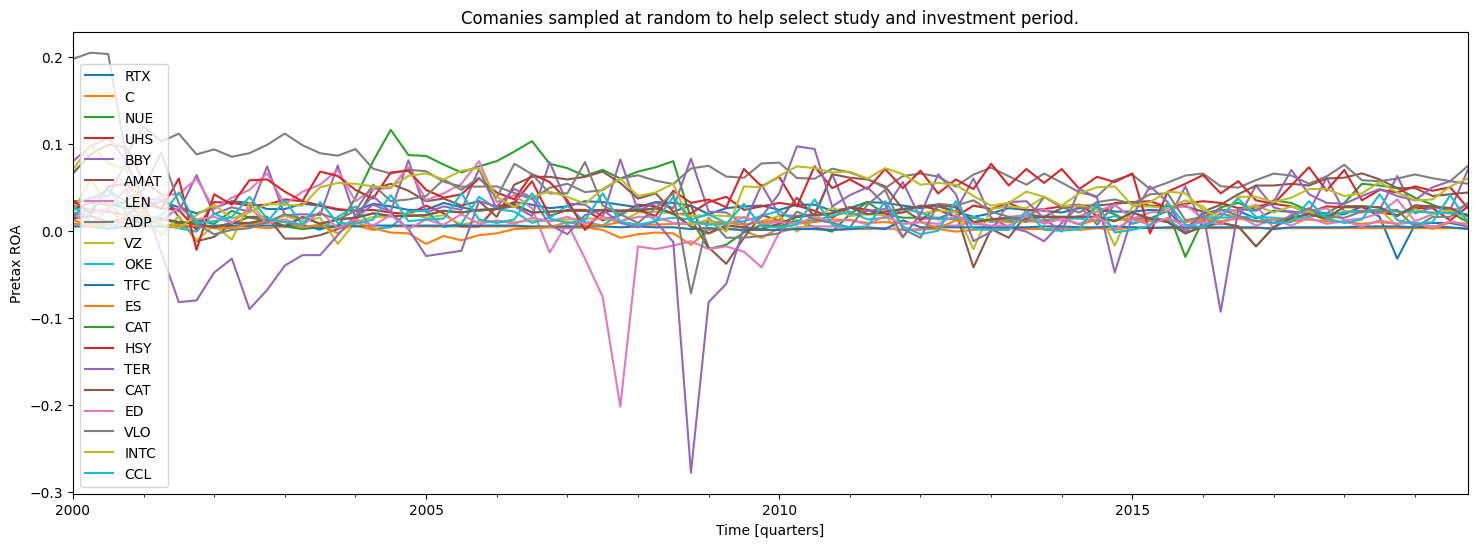

In [58]:
companies_df_position = [random.randint(0, len(ROA_df.columns)-1) for i in range(20)]
ax = ROA_df.iloc[:, companies_df_position].plot(kind="line", figsize=(18,6))
ax.set_title("Comanies sampled at random to help select study and investment period.")
ax.set_xlabel("Time [quarters]")
ax.set_ylabel(f"{name_of_metric}")

plt.show()


In [59]:
def create_study_invest_periods(start, study_quarters, investment_quarters):
    start_year, start_quarter = map(int, start.split('Q'))
    end_study_year = start_year + (start_quarter + study_quarters - 1) // 4
    end_study_quarter = (start_quarter + study_quarters - 1) % 4 + 1
    
    # Calculate the end of the study period
    end_study = f"{end_study_year}Q{end_study_quarter}"

    # Calculate the start of the investment period
    start_invest_year = end_study_year
    start_invest_quarter = end_study_quarter + 1  # Start of investment period is one quarter after the end of study
    if start_invest_quarter > 4:
        start_invest_year += 1
        start_invest_quarter -= 4

    end_invest_year = start_invest_year + (start_invest_quarter + investment_quarters - 1) // 4
    end_invest_quarter = (start_invest_quarter + investment_quarters - 1) % 4 + 1

    # Adjust the end quarter to be within 1 to 4
    if end_invest_quarter > 4:
        end_invest_quarter -= 4
        end_invest_year += 1

    start_invest = f"{start_invest_year}Q{start_invest_quarter}"
    end_invest = f"{end_invest_year}Q{end_invest_quarter}"

    return [start, end_study], [start_invest, end_invest]


study_period, invest_period = create_study_invest_periods(study_period_start,
                                                          study_period_length,
                                                          invest_period_length)
print(study_period)
print(invest_period)


['2000Q1', '2010Q1']
['2010Q2', '2011Q2']


### Step 7
[Steps backlink](#steps)

In [60]:
metric_averages = ROA_df.loc[study_period, :].mean(axis=0) # Only for study period
metric_averages.head()

AAPL    0.06850
ABT     0.18585
ADBE    0.27910
ADI     0.04800
ADP     0.13795
dtype: float64

### Step 8
[Steps backlink](#steps)

Outlier averages: 10

| Statistic          |   With outliers |   Without outliers |
|--------------------+-----------------+--------------------|
| Variance           |      0.00120185 |        0.000336863 |
| Mean               |      0.0276547  |        0.0244276   |
| Median             |      0.021      |        0.021       |
| Standard deviation |      0.0346678  |        0.0183538   |


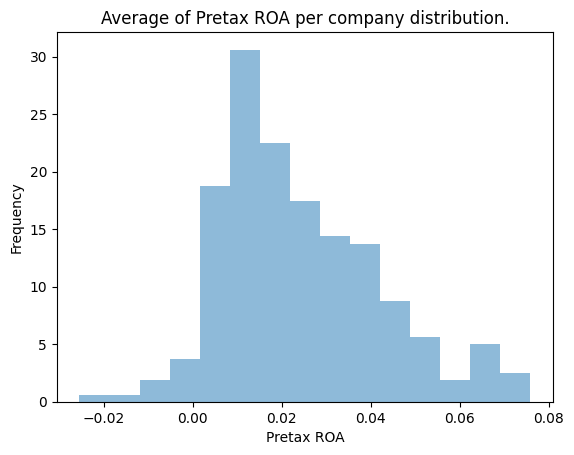

In [61]:

# Remove outliers
metric_averages_no_outliers, outliers = remove_outliers(metric_averages, 1.5)
print("Outlier averages: {}\n".format(len(outliers)))
# print(outliers)

# Print statistics
headers = [
    "Statistic", "With outliers", "Without outliers"
]
data = [
    ["Variance", metric_averages.var(), metric_averages_no_outliers.var()],
    ["Mean", metric_averages.mean(), metric_averages_no_outliers.mean()],
    ["Median", metric_averages.median(), metric_averages_no_outliers.median()],
    ["Standard deviation", metric_averages.std(), metric_averages_no_outliers.std()]
]
table = tabulate(data, headers=headers, tablefmt='orgtbl')
print(table)

# Histogram
plt.hist(metric_averages_no_outliers, **hist_options)
plt.title(f"Average of {name_of_metric} per company distribution.")
plt.xlabel(f"{name_of_metric}")
plt.ylabel("Frequency")
plt.show()

### Step 9
[Steps backlink](#steps)

In [62]:
# Initially we create two portfolios, one for the companies above the median and another for the ones below
metric_averages_no_outliers.sort_values(inplace=True)

below_quantile_mask = metric_averages_no_outliers < metric_averages_no_outliers.quantile(quantile_criterion)
metric_averages_below = metric_averages_no_outliers[below_quantile_mask]
metric_averages_above = metric_averages_no_outliers[~below_quantile_mask]

### Step 10
[Steps backlink](#steps)

In [63]:
# Load or download returns, including SP500
yahoo_sp500_symbol = "^GSPC"
study_companies = metric_averages_no_outliers.index.to_list()
study_companies.append(yahoo_sp500_symbol)
returns_fetcher = ReturnsFetcher(os.path.join("..", "data", "pickled_data", "returns_data.pickle"))
quarterly_returns, daily_returns = returns_fetcher.fetch(study_companies, "geometric")
quarter_returns = pd.DataFrame(quarterly_returns)

# Per portfolio returns
above_portfolio = quarter_returns[metric_averages_above.index.to_list()].copy()
below_portfolio = quarter_returns[metric_averages_below.index.to_list()].copy()

returns = {}
returns["above median"] = above_portfolio.mean(axis=1)*100
returns["below median"] = below_portfolio.mean(axis=1)*100

# SP500 returns
returns["S&P500"] = quarter_returns[yahoo_sp500_symbol].copy()*100

In [64]:
def split_study_invest(returns: dict, study_period: list[pd.Period], invest_period: list[pd.Period]):
    split_dict = {
        "study_period": {},
        "invest_period": {}
    }

    for portfolio_key in returns:
        split_dict["study_period"][portfolio_key] = returns[portfolio_key][study_period[0]:study_period[1]]
        split_dict["invest_period"][portfolio_key] = returns[portfolio_key][invest_period[0]:invest_period[1]]

    return split_dict.copy()

def print_periods(study_invest_data: dict):
    for key in returns_split:
        study_invest = returns_split[key]
        for portfoio_key in study_invest:
            print(f"{key}. Start: {min(study_invest[portfoio_key].index)}, End: {max(study_invest[portfoio_key].index)}")

            
returns_split = split_study_invest(returns, study_period, invest_period)
print_periods(returns_split) # We visually check if the data is split how we need
            

study_period. Start: 2000Q1, End: 2010Q1
study_period. Start: 2000Q1, End: 2010Q1
study_period. Start: 2000Q1, End: 2010Q1
invest_period. Start: 2010Q2, End: 2011Q2
invest_period. Start: 2010Q2, End: 2011Q2
invest_period. Start: 2010Q2, End: 2011Q2


Before proceeding with calculating the difference and testing if it is statistically significant, let's visualize the returns of the portfolios and the SP500 for the investment period to get an idea of what to expect.

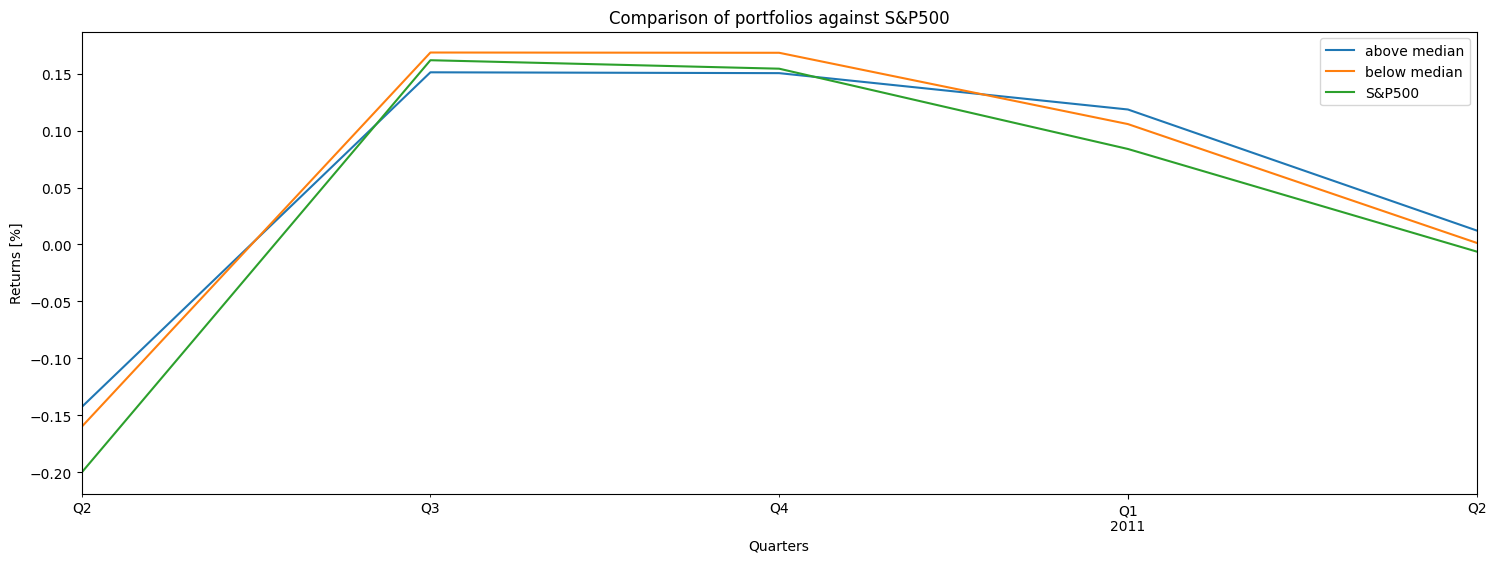

In [65]:
fig, ax = plt.subplots(figsize=(18,6))

for name, ret in returns_split["invest_period"].items():
    ret.plot(ax=ax, label=name)

ax.set_title("Comparison of portfolios against S&P500")
ax.set_xlabel("Quarters")
ax.set_ylabel("Returns [%]")
ax.legend()

plt.show()

To further understand what to expect, let's calculate some statistics for both study and investment periods. One would predict that the returns will be signficantly different, but let's see.

In [66]:
# Print statistics
statistics_o_returns = []
statistics_o_returns_headers = []
def print_statistics_portfolios(portfolios):
    # Prepare the data to print in a table
    headers = ["Statistic"] + [series_name for series_name in portfolios.keys()] 
    functions = {
        "Variance": pd.Series.var,
        "Mean": pd.Series.mean,
        "Median": pd.Series.median,
        "Standard deviation": pd.Series.std
    }

    # Calculate the data to display in the table
    data = []
    for name, function in functions.items():
        ist = [name]
        for portfolio in portfolios.values():
            ist += [function(portfolio)]
        data += [ist]

    table = tabulate(data, headers=headers, tablefmt='orgtbl')
    print(table)

    # Save data for result analysis. TODO: refactor to separate concern of saving data
    statistics_o_returns.append(data)
    statistics_o_returns_headers.append(headers)

for period in returns_split:
    print(f"\nStatistics for {period}")
    print_statistics_portfolios(returns_split[period])


Statistics for study_period
| Statistic          |   above median |   below median |      S&P500 |
|--------------------+----------------+----------------+-------------|
| Variance           |      0.0171204 |      0.0237408 |  0.0207609  |
| Mean               |      0.0307386 |      0.0265577 | -0.00873433 |
| Median             |      0.0518734 |      0.0521621 |  0.0202714  |
| Standard deviation |      0.130845  |      0.154081  |  0.144086   |

Statistics for invest_period
| Statistic          |   above median |   below median |    S&P500 |
|--------------------+----------------+----------------+-----------|
| Variance           |      0.0158197 |      0.0193564 | 0.022415  |
| Mean               |      0.0579221 |      0.056768  | 0.0387003 |
| Median             |      0.118515  |      0.105704  | 0.0838473 |
| Standard deviation |      0.125776  |      0.139127  | 0.149716  |


As expecter they strongly differ, we are working with time series that change over time, so it is expected that the returns of both periods will be different. This is another reason why we are using the median of the metric to create the portfolios, we are not interested in the absolute value of the metric, but in its relative position.
Also, this is another limitation of the present analysis. As future work it is adviced to work with the time series as they are, instead of using the median of the mean of the metric. An idea is to predict returns time series with machine learning or deep learning models based on the companies metrics and then create portfolios based on the predicted returns.

### Step 11
[Steps backlink](#steps)

In [67]:
def compare_returns(portfolio, baseline, significance_level=0.05):
    # Perform a paired t-test
    t_statistic, p_value = stats.ttest_rel(portfolio, baseline)

    is_or_not = f"not" if p_value >= significance_level else ""
    print(f"The difference is {is_or_not} statistically significant.")

    return t_statistic, p_value

baseline_key = "S&P500"
p_values = []
for key in returns:
    if key == baseline_key:
        continue

    t_statistic, p_value = compare_returns(returns_split["invest_period"][key], returns_split["invest_period"][baseline_key])
    p_values.append(p_value)

    # Check if it did better or worse
    if t_statistic > 0:
        print(f"{key} portfolio performed better than {baseline_key}")
    else:
        print(f"{key} portfolio performed worse than the {baseline_key}")

The difference is not statistically significant.
above median portfolio performed better than S&P500
The difference is  statistically significant.
below median portfolio performed better than S&P500


If they are both statistically significant we need to know which one is better. If not and they are both not statistically significant we discard the metric from our analysis.

In [68]:
t_statistic, p_value = compare_returns(returns_split["invest_period"]["above median"], returns_split["invest_period"]["below median"])

# Check if it did better or worse
if [p_value>=0.05 for p_value in p_values]:
    pass
else:
    if t_statistic > 0:
        print("above median portfolio performed better than below median portfolio")
    else:
        print("below median portfolio performed better than above median portfolio")

The difference is not statistically significant.


This result can be further explained by looking at the mean and variance values calculated in the tables a few cells above.

### Step 12
[Steps backlink](#steps)

In [71]:
def save_statistics_porfolios():
    for i, period in enumerate(returns_split):
        df_returns = pd.DataFrame(statistics_o_returns[i], columns=statistics_o_returns_headers[i])
        df_returns.set_index("Statistic")
        df_returns.to_excel(f"../data/results/{name_of_metric}returns_of_{period}.xlsx")


def save_portfolio_symbols():
    with open(f"../data/results/{name_of_metric}above_porfolio_symbols.txt", "w+") as output_f:
        output_f.write(str(metric_averages_above.index.to_list()))
    with open(f"../data/results/{name_of_metric}below_porfolio_symbols.txt", "w+") as output_f:
        output_f.write(str(metric_averages_below.index.to_list()))
        

save_statistics_porfolios()
save_portfolio_symbols()